# Isolated forest

In [ ]:
# imports
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc

## Data preparation

In [ ]:
#Enable Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_raw = pd.read_csv("/content/drive/MyDrive/prozorro_full.csv")

data_raw = data_raw.drop(columns=['expected_value_category'])

In [ ]:

data = data_raw.copy()


In [ ]:
data_raw.head()

,tender_id,tender,expected_value,VAT,procurement_procedure,procedure_status,tender_status,announcement_date,organizer,winner,duration,price_per_unit,measurement,cpv_classification,number_of_participants,number_of_disqualifications,number_of_questions,number_of_requirements,number_of_complaints,number_of_monitorings
0,UA-2019-02-28-002408-a-L1,Послуги з повірки вимірювальної техніки,121055.96,без ПДВ,Закупівля без використання електронної системи...,Завершена закупівля,Завершено лот закупівлі,2019-02-28,"КОМУНАЛЬНЕ НЕКОМЕРЦІЙНЕ ПІДПРИЄМСТВО ""ТРЕТЯ ЧЕ...","ДЕРЖАВНЕ ПІДПРИЄМСТВО ""ЧЕРКАСЬКИЙ НАУКОВО-ВИРО...",0,121055.96,послуга,71630000-3 Послуги з технічного огляду та випр...,1,0,0,0,0,0
1,UA-2019-02-28-002407-a-L1,УПГГК 19Т-021: 15510000-6–Молоко та вершки.,1913450.00,з ПДВ,Допорогова закупівля,Завершена закупівля,Завершено лот закупівлі,2019-02-28,"Укргазвидобування"" в особі філії ""Управління з...",ФОП Сергієнко Володимир Іванович | 3019512776,102,20.40,кілограм,15510000-6 Молоко та вершки,5,0,1,0,0,0
2,UA-2019-02-28-002406-a-L1,Природний газ,176343.03,з ПДВ,Закупівля без використання електронної системи...,Завершена закупівля,Завершено лот закупівлі,2019-02-28,Відокремлений структурний підрозділ «Тернопіль...,"ДОЧІРНЄ ПІДПРИЄМСТВО ""ГАЗПОСТАЧ"" ТОВАРИСТВА З ...",0,11.79,метр кубічний,09120000-6 Газове паливо,1,0,0,0,0,0
3,UA-2019-02-28-002404-a-L1,код CPV за ДК 021:2015 45110000-1: Руйнування...,198000.00,без ПДВ,Закупівля без використання електронної системи...,Завершена закупівля,Завершено лот закупівлі,2019-02-28,"КОМУНАЛЬНЕ ПІДПРИЄМСТВО ""ПЕРСПЕКТИВА"" КРАСНОСІ...",ТОВ СТАНІ МАГНУМ | 22445949,0,198000.00,послуга,45110000-1 Руйнування та знесення будівель і з...,1,0,0,0,0,0
4,UA-2019-02-28-002403-a-L1,Картопля (Код за ДК 021:2015 - 03210000-6 Зерн...,980000.00,з ПДВ,Відкриті торги,Завершена закупівля,Завершено лот закупівлі,2019-02-28,Національна академія внутрішніх справ | 08751177,"ФЕРМЕРСЬКЕ ГОСПОДАРСТВО ""БІАТРІС"" | 34438448",32,9.36,кілограм,03210000-6 Зернові культури та картопля,2,0,0,0,0,0


In [ ]:
part_data = data_raw.sample(n=10000, random_state=42).reset_index(drop=True)

In [ ]:
train_data, temp_data = train_test_split(data, test_size=0.1, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Train: {len(train_data)} rows")
print(f"Validation: {len(val_data)} rows")
print(f"Test: {len(test_data)} rows")

Train: 2354317 rows
Validation: 130795 rows
Test: 130796 rows


In [ ]:
train_data.columns

Index(['tender_id', 'tender', 'expected_value', 'VAT', 'procurement_procedure',
       'procedure_status', 'tender_status', 'announcement_date', 'organizer',
       'winner', 'duration', 'price_per_unit', 'measurement',
       'cpv_classification', 'number_of_participants',
       'number_of_disqualifications', 'number_of_questions',
       'number_of_requirements', 'number_of_complaints',
       'number_of_monitorings'],
      dtype='object')

In [ ]:
numerical_cols = ['expected_value', 'price_per_unit', 'number_of_participants',
                      'number_of_disqualifications', 'number_of_questions', 'number_of_requirements',
                      'number_of_complaints', 'number_of_monitorings']
categorical_cols = ['procurement_procedure', 'VAT', 'procedure_status', 'tender_status']
drop_cols = [
    'tender_id', 'tender', 'announcement_date',
    'organizer', 'winner', 'measurement', 'cpv_classification'
]

def prepare_data(data, encoder=None, scaler=None, fit=False):
    if fit:
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded_cols = encoder.fit_transform(data[categorical_cols])
    else:
        encoded_cols = encoder.transform(data[categorical_cols])

    encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_cols))

    result = data.drop(columns=categorical_cols).reset_index(drop=True)
    result = pd.concat([result, encoded_df], axis=1)
    for col in numerical_cols:
        result[col] = result[col].replace('-', np.nan)
        result[col] = pd.to_numeric(result[col], errors='coerce')
    result[numerical_cols] = result[numerical_cols].fillna(0)

    if fit:
        scaler = StandardScaler()
        result[numerical_cols] = scaler.fit_transform(result[numerical_cols])
    else:
        result[numerical_cols] = scaler.transform(result[numerical_cols])

    result = result.drop(columns=drop_cols)
    for col in result.columns:
      result[col] = pd.to_numeric(result[col], errors='coerce')

    result = result.fillna(0)

    return result, encoded_df, encoder, scaler


In [ ]:
# Training phase — fit encoder and scaler
train_prepared, _, encoder, scaler = prepare_data(train_data, fit=True)

# Validation and test phase — reuse encoder and scaler
val_prepared, _, _, _ = prepare_data(val_data, encoder=encoder, scaler=scaler)
test_prepared, _, _, _ = prepare_data(test_data, encoder=encoder, scaler=scaler)

data_prepared, _, _, _ = prepare_data(data, encoder=encoder, scaler=scaler)

In [ ]:
train_prepared.head(2)
print(train_prepared.dtypes.unique())
print(val_prepared.dtypes.unique())

[dtype('float64')]
[dtype('float64')]


In [ ]:
train_prepared.head()

,expected_value,duration,price_per_unit,number_of_participants,number_of_disqualifications,number_of_questions,number_of_requirements,number_of_complaints,number_of_monitorings,procurement_procedure_Відкриті торги з особливостями,...,procedure_status_Завершена закупівля,procedure_status_Закупівля не відбулась,procedure_status_Кваліфікація переможця,procedure_status_Очікування пропозицій,procedure_status_Прекваліфікація,procedure_status_Прекваліфікація (період оскаржень),procedure_status_Пропозиції розглянуто,tender_status_Завершено лот закупівлі,tender_status_Неуспішний лот закупівлі,tender_status_Скасовано лот закупівлі
0,-0.018471,12.0,-0.021221,-0.326613,-0.264651,-0.17207,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.039946,0.0,-0.032327,-0.326613,-0.264651,-0.17207,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.039804,0.0,-0.032161,-0.326613,-0.264651,-0.17207,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.033705,28.0,-0.035173,-0.326613,-0.264651,-0.17207,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.039291,26.0,-0.031570,-0.326613,-0.264651,-0.17207,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
test_prepared.head()

,expected_value,duration,price_per_unit,number_of_participants,number_of_disqualifications,number_of_questions,number_of_requirements,number_of_complaints,number_of_monitorings,procurement_procedure_Відкриті торги з особливостями,...,procedure_status_Завершена закупівля,procedure_status_Закупівля не відбулась,procedure_status_Кваліфікація переможця,procedure_status_Очікування пропозицій,procedure_status_Прекваліфікація,procedure_status_Прекваліфікація (період оскаржень),procedure_status_Пропозиції розглянуто,tender_status_Завершено лот закупівлі,tender_status_Неуспішний лот закупівлі,tender_status_Скасовано лот закупівлі
0,0.034440,13.0,0.054642,-0.326613,-0.264651,-0.172070,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.012504,13.0,-0.035221,-0.326613,-0.264651,-0.172070,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.021297,0.0,-0.010524,-0.326613,-0.264651,-0.172070,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.021387,0.0,-0.010629,-0.326613,-0.264651,-0.172070,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.040884,43.0,-0.035221,1.395698,-0.264651,1.008494,-0.105524,-0.098577,-0.1069,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#Fit the Isolation Forest (defined the best parameters)
iso = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.01,
    random_state=42
)
iso.fit(train_prepared)



IsolationForest(contamination=0.01, random_state=42)

In [ ]:
X = train_prepared.values if hasattr(train_prepared, "values") else train_prepared

S = -iso.decision_function(X)

n_samples, n_dims = X.shape
rng = np.random.RandomState(42)
mins = X.min(axis=0)
maxs = X.max(axis=0)
U = rng.uniform(mins, maxs, size=(n_samples, n_dims))
S_U = -iso.decision_function(U)

alphas = np.linspace(0.01, 0.99, 100)

mass = []
volume = []
for alpha in alphas:
    t = np.quantile(S, 1 - alpha)
    mass.append(np.mean(S >= t))
    volume.append(np.mean(S_U >= t))

aumv = auc(alphas, volume)

em = []
for alpha, t in zip(alphas, [np.quantile(S, 1 - a) for a in alphas]):
    em_value = np.mean(np.maximum(S - t, 0)) - alpha * t
    em.append(em_value)

auem = auc(alphas, em)

print(f"AUC Mass–Volume (AUMV): {aumv:.4f}")
print(f"AUC Excess–Mass (AUEM):  {auem:.4f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


AUC Mass–Volume (AUMV): 0.9800
AUC Excess–Mass (AUEM):  0.1525


In [ ]:
train_data['anomaly_score'] = iso.decision_function(train_prepared)
train_data['is_anomaly'] = iso.predict(train_prepared) == -1



In [ ]:
train_data[train_data['is_anomaly']]

,tender_id,tender,expected_value,VAT,procurement_procedure,procedure_status,tender_status,announcement_date,organizer,winner,...,measurement,cpv_classification,number_of_participants,number_of_disqualifications,number_of_questions,number_of_requirements,number_of_complaints,number_of_monitorings,anomaly_score,is_anomaly
1249668,UA-2020-12-22-017246-c-L1,20Т-188_43610000-2 – Частини бурильних машин (...,2.012107e+07,з ПДВ,Відкриті торги із публікацією англ. мовою,Завершена закупівля,Завершено лот закупівлі,2020-12-22,"АТ ""УКРГАЗВИДОБУВАННЯ"" | 30019775","ТОВ ""НАДРА ІНЖИНІРИНГ"" | 42925254",...,-,43610000-2 Частини бурильних машин,4,0,0,0,0,1,-0.000561,True
638634,UA-2018-01-12-000219-c-L1,ДК021-2015: 34140000-0 Великовантажні мототран...,2.000000e+07,з ПДВ,Відкриті торги із публікацією англ. мовою,Відмінена закупівля,Скасовано лот закупівлі,2018-01-12,"КОМУНАЛЬНЕ ПІДПРИЄМСТВО ""МІЖНАРОДНИЙ АЕРОПОРТ ...",-,...,одиниця,34140000-0 Великовантажні мототранспортні засоби,0,0,0,0,0,0,-0.012089,True
1364923,UA-2020-02-05-000747-c-L1,Код ДК 021:2015 - 31170000-8 Трансформатори (Т...,1.228996e+07,з ПДВ,Відкриті торги із публікацією англ. мовою,Відмінена закупівля,Скасовано лот закупівлі,2020-02-05,"ПУБЛІЧНЕ АКЦІОНЕРНЕ ТОВАРИСТВО ""ЗАПОРІЖЖЯОБЛЕН...",-,...,штука,31170000-8 Трансформатори,4,0,1,0,1,0,-0.039552,True
1542369,UA-2020-09-28-000848-a-L1,«КОД ДК 021:2015 34120000-4 - МОТОТРАНСПОРТНІ ...,2.560000e+06,з ПДВ,Відкриті торги із публікацією англ. мовою,Відмінена закупівля,Скасовано лот закупівлі,2020-09-28,"КОМУНАЛЬНЕ ПІДПРИЄМСТВО ""ДНІПРОВОДОКАНАЛ"" ДНІП...",-,...,штука,34121000-1 Міські та туристичні автобуси,3,0,0,1,3,0,-0.020946,True
2031365,UA-2020-04-17-003675-c-L1,"Відновлення асфальтобетонних, ФЕМових покритті...",3.500000e+07,з ПДВ,Відкриті торги із публікацією англ. мовою,Закупівля не відбулась,Неуспішний лот закупівлі,2020-04-17,КОМУНАЛЬНЕ ПІДПРИЄМСТВО ВИКОНАВЧОГО ОРГАНУ КИЇ...,-,...,послуга,"45230000-8 Будівництво трубопроводів, ліній зв...",1,0,0,0,0,0,-0.022254,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2285903,UA-2020-11-13-005798-c-L1,за кодом CPV за ДК 021:2015 – 09310000-5 Елект...,1.353337e+08,з ПДВ,Відкриті торги із публікацією англ. мовою,Закупівля не відбулась,Неуспішний лот закупівлі,2020-11-13,"Комунальне підприємство ""Теплопостачання міста...",-,...,кіловат-година,09310000-5 Електрична енергія,1,0,1,0,0,0,-0.051673,True
649150,UA-2018-01-04-000345-a-L1,Шарнірно-зчленований самоскид вантажопідйомніс...,2.000000e+08,з ПДВ,Відкриті торги із публікацією англ. мовою,Завершена закупівля,Завершено лот закупівлі,2018-01-04,"АКЦІОНЕРНЕ ТОВАРИСТВО ""ОБ'ЄДНАНА ГІРНИЧО-ХІМІЧ...",ТОВАРИСТВО З ОБМЕЖЕНОЮ ВІДПОВІДАЛЬНІСТЮ З ІНОЗ...,...,штука,34140000-0 Великовантажні мототранспортні засоби,3,1,0,2,2,0,-0.044955,True
666326,UA-2017-08-18-001183-a-L3,"Лот №3 - Послуги похило-скерованого буріння, с...",2.402727e+07,з ПДВ,Допорогова закупівля,Завершена закупівля,Завершено лот закупівлі,2017-08-18,"АТ ""УКРГАЗВИДОБУВАННЯ"" | 30019775","ТОВ ""ВЕЗЕРФОРД УКРАЇНА"" | 35633533",...,послуга,"76110000-7 Послуги, пов’язані з видобуванням газу",7,0,5,0,0,0,-0.001331,True
1400804,UA-2017-03-15-000749-c-L1,Дизельне паливо наливом,3.933333e+07,без ПДВ,Відкриті торги із публікацією англ. мовою,Відмінена закупівля,Скасовано лот закупівлі,2017-03-15,"ДП ""Адміністрація морських портів України"" | 3...",-,...,кілограм,09130000-9 Нафта і дистиляти,2,0,0,0,0,0,-0.063363,True


In [ ]:
summary = train_data['is_anomaly'].value_counts().rename(index={False: 'normal', True: 'anomaly'}).to_frame('count')
summary

,count
is_anomaly,
normal,2330819
anomaly,23498


In [ ]:
# Split normal vs anomalies
normal = train_data[~train_data['is_anomaly']]
anomalies = train_data[train_data['is_anomaly']]



In [ ]:
plot_df = anomalies[numerical_cols].reset_index().melt(
    id_vars='index', var_name='feature', value_name='value'
)


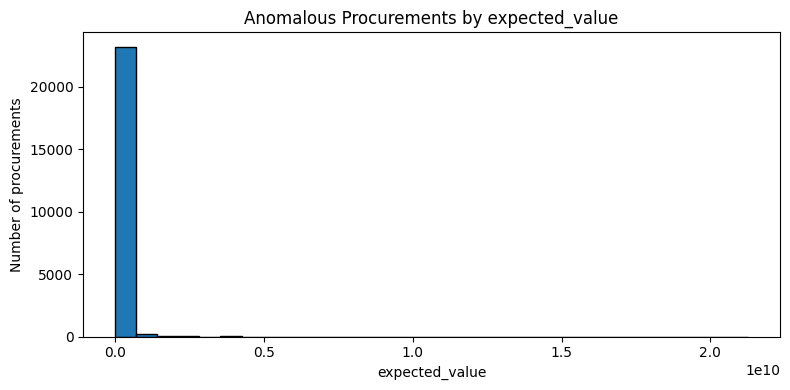

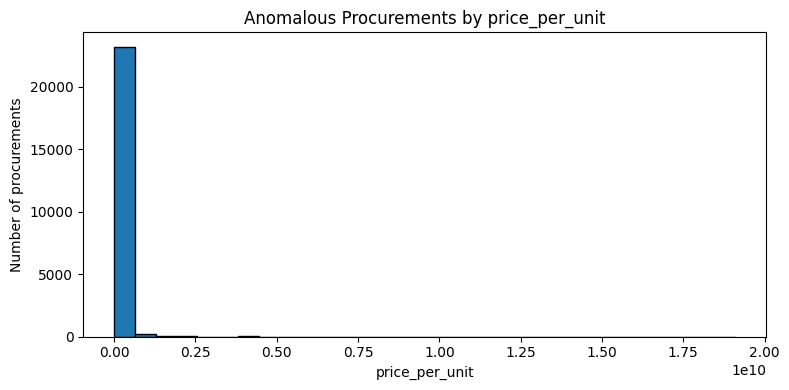

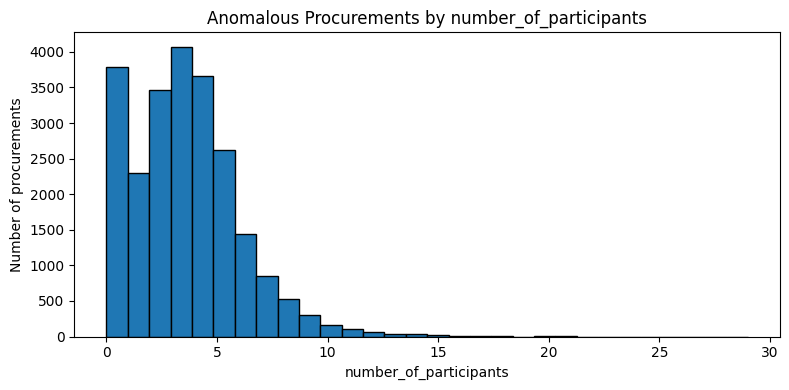

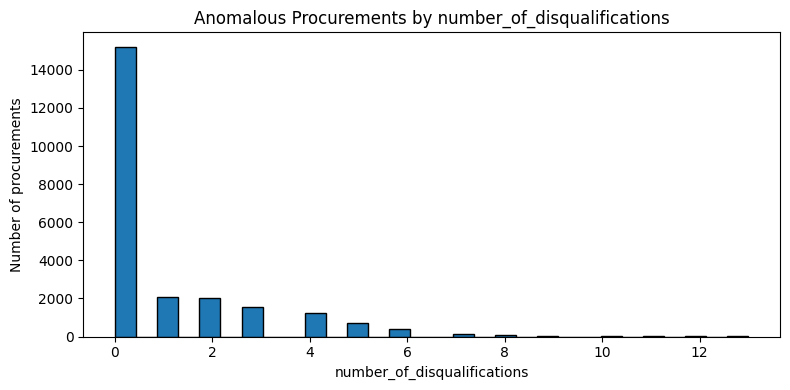

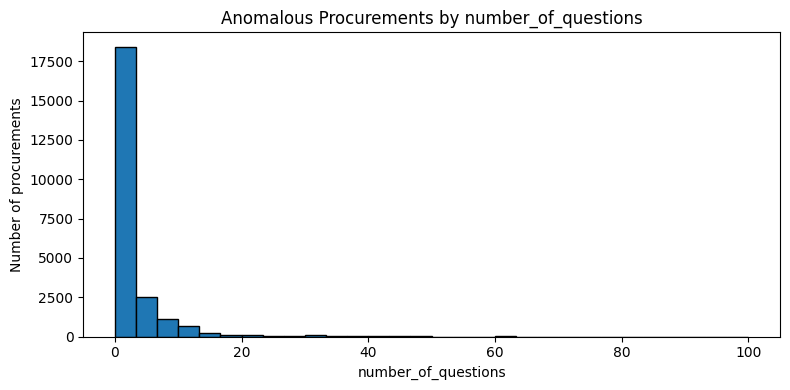

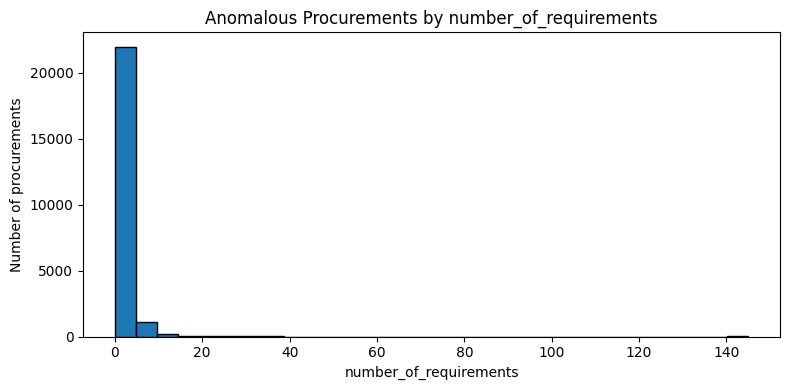

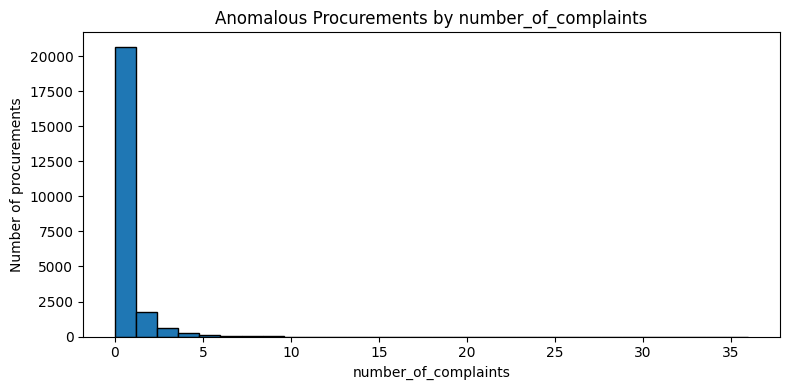

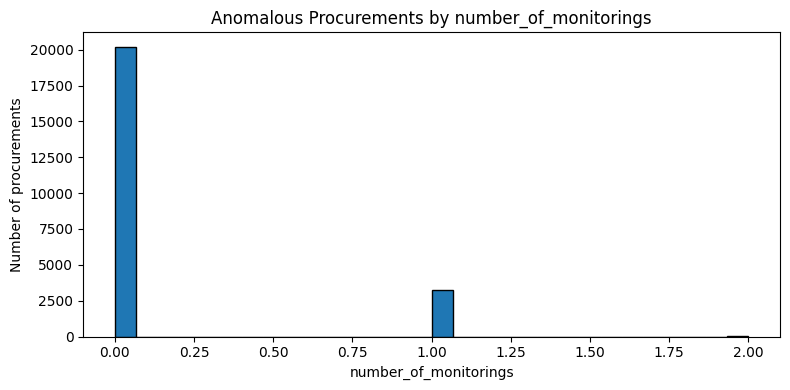

In [ ]:
#Make plot more consencus
feature_order = numerical_cols
y_positions = {feat: i for i, feat in enumerate(feature_order)}
plot_df['y'] = plot_df['feature'].map(y_positions)



for feature in feature_order:
    plt.figure(figsize=(8, 4))
    plt.hist(anomalies[feature], bins=30, edgecolor='black')
    # if feature in ["expected_value", "price_per_unit"]:
    #   plt.xscale('log')
    plt.xlabel(f'{feature}')
    plt.ylabel('Number of procurements')
    plt.title(f'Anomalous Procurements by {feature}')
    plt.tight_layout()
    plt.show()

In [ ]:
test_tsne =  pd.read_csv("/content/drive/MyDrive/test_prepared_half.csv")

In [ ]:
test_tsne_dropped = test_tsne.drop(columns=drop_cols)

# 2) Coerce all columns to numeric, turning bad values into NaN
for col in test_tsne_dropped.columns:
    test_tsne_dropped[col] = pd.to_numeric(test_tsne_dropped[col], errors='coerce')

# 3) Drop only the rows with ANY NaNs
#    This produces test_tsne_clean with the same row‐labels as test_tsne_dropped
test_tsne_clean = test_tsne_dropped.dropna(axis=0, how='any')

# 4) Slice the original test_tsne to keep exactly those same rows
test_tsne = test_tsne.loc[test_tsne_clean.index]

# 5) Now compute and assign your scores
test_tsne['anomaly_score'] = iso.decision_function(test_tsne_clean)
test_tsne['is_anomaly']   = iso.predict(test_tsne_clean) == -1

In [ ]:
summary = test_tsne['is_anomaly'].value_counts().rename(index={False: 'normal', True: 'anomaly'}).to_frame('count')
summary

,count
is_anomaly,
normal,52552
anomaly,122


In [ ]:
test_tsne = test_tsne.dropna(axis=0, how='any')

In [ ]:
# 2. t-SNE visualization (make it for small amount of data)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(test_tsne_clean)

In [ ]:
test_tsne['TSNE1'], test_tsne['TSNE2'] = X_tsne[:, 0], X_tsne[:, 1]

In [ ]:
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=test_tsne, x='TSNE1', y='TSNE2',
    hue='is_anomaly', palette={True: '#d52a9d', False: '#1ecbe1'},
    alpha=0.6
)
plt.title("t-SNE: Procurement Anomalies")
plt.show()

ValueError: Could not interpret value `TSNE1` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [ ]:
test_data['anomaly_score'] = iso.decision_function(test_prepared)
test_data['is_anomaly']   = iso.predict(test_prepared) == -1

<ipython-input-60-5f0dd84b77c7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


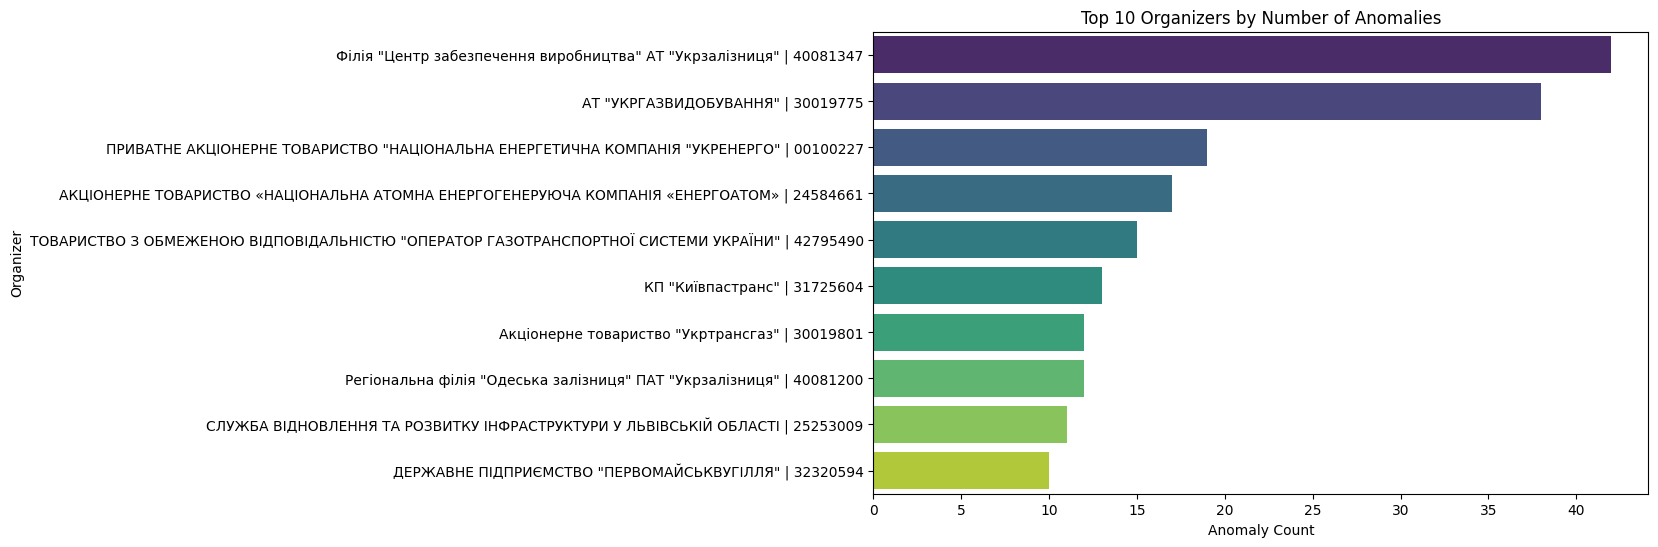

In [ ]:

# 4. Top organizers by anomaly count
anomalies = test_data[test_data['is_anomaly']]
top_orgs = anomalies['organizer'].value_counts().nlargest(10).reset_index()
top_orgs.columns = ['Organizer', 'Anomaly Count']

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_orgs, x='Anomaly Count', y='Organizer',
    palette='viridis'
)
plt.title("Top 10 Organizers by Number of Anomalies")
plt.show()

In [ ]:
test_prepared['anomaly_score'] = iso.decision_function(test_prepared)
test_prepared['is_anomaly']   = iso.predict(test_prepared) == -1

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- anomaly_score


In [ ]:
procurement_cols = [col for col in test_prepared.columns if col.startswith('procurement_procedure_')]

test_prepared['procedure_type'] = test_prepared[procurement_cols].idxmax(axis=1)
test_prepared['procedure_type'] = test_prepared['procedure_type'].str.replace('procurement_procedure_', '', regex=False)

procurement_summary = test_prepared.groupby('procedure_type')['is_anomaly'].agg(['count', 'sum'])
procurement_summary['anomaly_ratio'] = procurement_summary['sum'] / procurement_summary['count']
procurement_summary = procurement_summary.sort_values('sum', ascending=False)

KeyError: 'Column not found: is_anomaly'

In [ ]:
plt.figure(figsize=(15, 7))
sns.barplot(
    data=procurement_summary.reset_index(),
    x='sum',
    y='procedure_type',
    hue='procedure_type',
    palette='husl',
    legend=False
)
plt.title("Number of Anomalies per Procurement Procedure Type")
plt.xlabel("Number of Anomalies")
plt.ylabel("Procurement Procedure")
plt.show()

# Implementation

In [ ]:
import requests
import pandas as pd
import numpy as np
from datetime import datetime
from tqdm import tqdm  # nice progress bar

In [ ]:
def fetch_page(page=0, size=100, status="complete"):
    url = "https://public.api.openprocurement.org/api/2.5/tenders"
    params = {
        "offset": page * size,
        "limit":  size,
        "mode":   "all",
        "status": status
    }
    r = requests.get(url, params=params)
    r.raise_for_status()
    return r.json()["data"]

In [ ]:
# Example: grab first 5×100 = 500 tenders
raw = []
for p in range(5):
    raw.extend(fetch_page(page=p, size=100))


In [ ]:
raw

In [ ]:
df.head()

In [ ]:
def parse_date(s):
    try:
        return datetime.fromisoformat(s).date()
    except:
        return pd.NaT

def mk_record(t):
    # 2.1 base scalars
    rec = {
        "tender_id":            t["id"],
        "tender":               t.get("title",""),
        "expected_value":       t.get("value",{}).get("amount", np.nan),
        "VAT":                  "з ПДВ" if t.get("value",{}).get("valueAddedTaxIncluded") else "без ПДВ",
        "procurement_procedure":t.get("procurementMethodType",""),
        "procedure_status":     t.get("status",""),
        "announcement_date":    parse_date(t.get("tenderPeriod",{}).get("startDate","")),
        "organizer":            t.get("procuringEntity",{}).get("name",""),
    }
    # 2.2 lots → tender_status
    lots = t.get("lots",[])
    rec["tender_status"] = lots[0].get("status","") if lots else ""

    # 2.3 duration in days
    start = parse_date(t.get("tenderPeriod",{}).get("startDate",""))
    end   = parse_date(t.get("tenderPeriod",{}).get("endDate",""))
    rec["duration"] = (end - start).days if pd.notna(start) and pd.notna(end) else np.nan

    # 2.4 items → price_per_unit, measurement, cpv_classification
    items = t.get("items",[])
    if items:
        total_qty = sum(it.get("quantity",0) for it in items) or np.nan
        rec["price_per_unit"]     = rec["expected_value"] / total_qty if total_qty else np.nan
        rec["measurement"]        = items[0].get("unit",{}).get("name","")
        rec["cpv_classification"] = items[0].get("classification",{}).get("id","")
    else:
        rec["price_per_unit"] = np.nan
        rec["measurement"] = ""
        rec["cpv_classification"] = ""

    # 2.5 awards → winner (first active)
    awards = t.get("awards",[])
    winners = [a for a in awards if a.get("status")=="active"]
    if winners and winners[0].get("suppliers"):
        rec["winner"] = winners[0]["suppliers"][0].get("name","")
    else:
        rec["winner"] = ""

    # 2.6 bids → participants & disqualifications
    bids = t.get("bids",{}).get("details",[])
    rec["number_of_participants"]      = len(bids)
    rec["number_of_disqualifications"] = sum(1 for b in bids if b.get("status")!="active")

    # 2.7 questions, criteria, complaints, monitoring → lengths
    rec["number_of_questions"]    = len(t.get("questions",[]))
    rec["number_of_requirements"] = len(t.get("criteria",[]))
    rec["number_of_complaints"]   = len(t.get("complaints",[]))
    rec["number_of_monitorings"]  = len(t.get("monitoring",[]))

    return rec

# Build the DataFrame
df_api = pd.DataFrame([mk_record(t) for t in df])

# Now df_api has exactly your 20 raw features.
# You can run your `prepare_data` on df_api, then score with IsolationForest:

# Example:
# df_prep, _, encoder, scaler = prepare_data(df_api, fit=True)
# df_api["anomaly_score"] = iso.decision_function(df_prep)
# df_api["is_anomaly"]   = iso.predict(df_prep) == -1

print(df_api.columns.tolist())
print(df_api.head())